## Plot Benchmark Data
This python notebook uses `matplotlib` and `pandas`.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def readspeed_hist(df, local, fs, process, **kwargs) :
    """Get slice from pandas.DataFrame and plot histogram
    
    Histogram is filled with time / size * 10 ** 6 so that the
    filled variable has units of s / MB. The histogram generated
    is given a label corresponding to the inputs local and fs.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe of data read in during runs
    local : bool
        copied to local scratch run or not?
    fs : str
        'hdfs' or 'zfs' filesystem
    kwargs : dict
        passed on to plt.hist
    """
    sl = df[(df['local'] == local) & (df['filesystem'] == fs) & (df['process']==process)]
    local_str = 'remote read'
    if local :
        local_str = 'cp to scratch then read'
    data = sl['size']/sl['time']/10**6
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, label = f'{fs} {local_str}', histtype='step', **kwargs)
    
def readspeed_comp(df,title, **kwargs) :
    """Generate a comparison plot from the input file
    
    Four histograms are put onto the plot using the hist
    function above - they involve all four combinations
    of the two local options (True/False) and the two filesystem
    options ('hdfs'/'zfs').
    
    Parameters
    ----------
    df : str or pandas.DataFrame
        Filename with data to read from
    title : str, optional
        Title to add to plot, use filename by default
    kwargs : dict
        Passed on to hist
    """
    
    if isinstance(df,str) :
        df = pd.read_csv(df)
    readspeed_hist(df, True , 'hdfs', True, ls='--', ec='steelblue', **kwargs)
    readspeed_hist(df, False, 'hdfs', True, ls='-' , ec='steelblue', **kwargs)
    readspeed_hist(df, True , 'zfs' , True, ls='--', ec='salmon'   , **kwargs)
    readspeed_hist(df, False, 'zfs' , True, ls='-' , ec='salmon'   , **kwargs)
    plt.xlabel('Read Speed [MBps]',size='xx-large')
    plt.ylabel('Fraction of Jobs',size='xx-large')
    plt.yscale('log')
    plt.title(title,size='xx-large')
    plt.legend()
    return df

def time_hist(df, local, fs, process, **kwargs) :
    """Get slice from pandas.DataFrame and plot histogram
    
    Histogram is filled with time / size * 10 ** 6 so that the
    filled variable has units of s / MB. The histogram generated
    is given a label corresponding to the inputs local and fs.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe of data read in during runs
    local : bool
        copied to local scratch run or not?
    fs : str
        'hdfs' or 'zfs' filesystem
    kwargs : dict
        passed on to plt.hist
    """
    sl = df[(df['local'] == local) & (df['filesystem'] == fs) & (df['process']==process)]
    local_str = 'remote read'
    if local :
        local_str = 'cp to scratch then read'
    data = sl['time']
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, label = f'{fs} {local_str}', histtype='step', **kwargs)
    
def time_comp(df,title, **kwargs) :
    """Generate a comparison plot from the input file
    
    Four histograms are put onto the plot using the hist
    function above - they involve all four combinations
    of the two local options (True/False) and the two filesystem
    options ('hdfs'/'zfs').
    
    Parameters
    ----------
    df : str or pandas.DataFrame
        Filename with data to read from
    title : str, optional
        Title to add to plot, use filename by default
    kwargs : dict
        Passed on to hist
    """
    
    if isinstance(df,str) :
        df = pd.read_csv(df)
    
    time_hist(df, True , 'hdfs', True, ls='--', ec='steelblue', **kwargs)
    time_hist(df, False, 'hdfs', True, ls='-' , ec='steelblue', **kwargs)
    time_hist(df, True , 'zfs' , True, ls='--', ec='salmon'   , **kwargs)
    time_hist(df, False, 'zfs' , True, ls='-' , ec='salmon'   , **kwargs)
    plt.xlabel('Job Time [s]',size='xx-large')
    plt.ylabel('Fraction of Jobs',size='xx-large')
    plt.yscale('log')
    plt.title(title,size='xx-large')
    plt.legend()
    return df

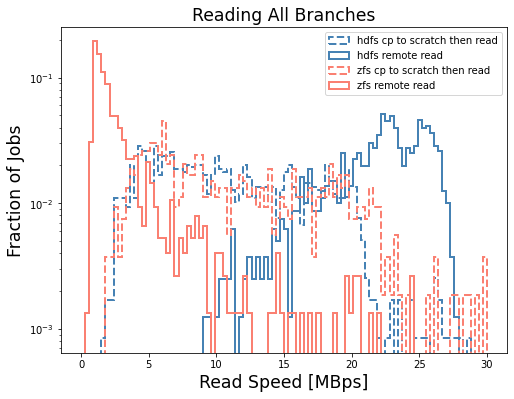

In [65]:
plt.figure(figsize=(8,6))
df = readspeed_comp('all-branches-runs.csv','Reading All Branches', bins=100,range=(0.,30.),lw=2.)
plt.show()

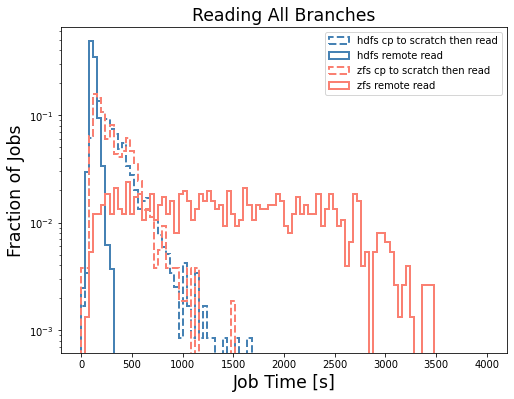

In [66]:
plt.figure(figsize=(8,6))
df = time_comp(df,'Reading All Branches', bins=100,range=(0.,4000.),lw=2.)
plt.show()

## Qualitative Notes
- HDFS remote read is only slightly faster (in time) compared to ZFS cp to scratch then read
- HDFS jobs fail much more regularly due to ROOT's inability to open the file on HDFS, resubmission seems to fix the issue but is annoying for the user
- Copying output files to HDFS also fails more regularly and requires the user to implement a [a special copying function](https://github.com/UMN-CMS/ldmx-scripts/blob/4f7b2f532beea31533b5cf77084974f3bfe56694/batch/run_ldmx.sh#L63-L116) which performs multiple copy attempts and checks that the full file was actually copied